In [1]:
! pip install matplotlib jinja2

In [2]:
import os
import sys
import logging
from dotenv import load_dotenv

import dspy
from dspy.datasets.gsm8k import GSM8K, gsm8k_metric
from dspy.evaluate import Evaluate
from dspy.teleprompt import MIPROv2
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
from mcts_llm.mctsr import MCTSr

load_dotenv()

logging.basicConfig(level=logging.WARNING)
logging.getLogger("mcts-llm").setLevel(logging.INFO)

np.random.seed(42)

/Users/yolo/miniconda/envs/mcts-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ollama = dspy.LM(
    model="ollama/qwen2.5:7b-instruct", 
    model_type="chat",
    temperature=1.0,
    max_tokens=1024,
    num_ctx=8192,
    timeout_s=600
)
openai = dspy.LM(
    model="deepseek/deepseek-chat", 
    model_type="chat",
    api_key=os.environ["DEEPSEEK_API_KEY"], 
    base_url=os.environ["DEEPSEEK_BASE_URL"], 
    temperature=1.0,
    max_tokens=4096
)
dspy.settings.configure(lm=ollama, experimental=True)

In [4]:
gsm8k = GSM8K()

100%|██████████| 1319/1319 [00:00<00:00, 58474.65it/s]


In [5]:
gsm8k_trainset = [
    dspy.Example(
        problem=example['question'], 
        gold_reasoning=example['gold_reasoning'],
        answer=example['answer']
    ).with_inputs("problem") for example in gsm8k.train
]
np.random.shuffle(gsm8k_trainset)
gsm8k_trainset[:10]

[Example({'problem': 'A bowl of fruit holds 18 peaches. Four of the peaches are ripe and two more ripen every day, but on the third day three are eaten. How many more ripe peaches than unripe peaches are in the bowl after five days?', 'gold_reasoning': 'In 5 days, 2 * 5 = <<2*5=10>>10 peaches will ripen. With the 4 that were already ripe, there will be 14 peaches that have ripened. Three were eaten, so there will be 14 - 3 = <<14-3=11>>11 ripe peaches left. There are 18 - 14 = <<18-14=4>>4 unripe peaches left. Therefore, there will be 11 - 4 = <<11-4=7>>7 more ripe peaches than unripe peaches in the bowl after five days.', 'answer': '7'}) (input_keys={'problem'}),
 Example({'problem': 'John needs to replace his shoes so he decides to buy a $150 pair of Nikes and a $120 pair of work boots.  Tax is 10%.  How much did he pay for everything?', 'gold_reasoning': 'The shoes cost $150 + $120 = $<<150+120=270>>270 The tax was $270 * .1 = $<<270*.1=27>>27 So the total cost was $270 + $27 = $<<2

In [6]:
gsm8k_testset = [
    dspy.Example(
        problem=example['question'], 
        gold_reasoning=example['gold_reasoning'],
        answer=example['answer']
    ).with_inputs("problem") for example in gsm8k.test
]
np.random.shuffle(gsm8k_testset)
gsm8k_testset[:10]

[Example({'problem': "Great Grandma Jones has three children.  And each of her children has three children of their own, who are Great Grandma Jones' grandchildren.  And each of these grandchildren has three babies of their own, who are Great Grandma Jones' great grand-babies.  If all of the family show up at the family reunion, how many great grand-babies will be there for Great Grandma Jones to kiss?", 'gold_reasoning': 'Three children each have three children, for a total of 3*3=<<3*3=9>>9 grandchildren. 9 grandchildren each have 3 babies, for a total of 9*3=<<9*3=27>>27 great grand-babies', 'answer': '27'}) (input_keys={'problem'}),
 Example({'problem': 'Mark was unwell for 3 months, during which he lost 10 pounds per month. If his final weight was 70 pounds, what was his initial weight?', 'gold_reasoning': "Since Mark was losing 10 pounds each month, in 3 months he lost 10 * 3 = <<10*3=30>>30 pounds. Adding the weight lost to the final weight gives an initial weight of 70 + 30 = <

In [7]:
evaluate = Evaluate(
    devset=gsm8k_testset[:24], 
    metric=gsm8k_metric, 
    num_threads=36, 
    display_progress=True,
    display_table=20,
)

In [8]:
evaluate(MCTSr(samples_per_node=5, default_uct_score=1e8))

Average Metric: 19 / 24  (79.2): 100%|██████████| 24/24 [26:57<00:00, 67.40s/it] 


,problem,gold_reasoning,example_answer,pred_answer,gsm8k_metric
0,"Great Grandma Jones has three children. And each of her children has three children of their own, who are Great Grandma Jones' grandchildren. And each...","Three children each have three children, for a total of 3*3=<<3*3=9>>9 grandchildren. 9 grandchildren each have 3 babies, for a total of 9*3=<<9*3=27>>27 great grand-babies",27,There will be 27 great-grandbabies at the family reunion.,✔️ [True]
1,"Mark was unwell for 3 months, during which he lost 10 pounds per month. If his final weight was 70 pounds, what was his initial...","Since Mark was losing 10 pounds each month, in 3 months he lost 10 * 3 = <<10*3=30>>30 pounds. Adding the weight lost to the...",100,I don't know.,
2,"On Tuesday, Peter wants to exercise for twice the amount of time he did on Monday and Sunday combined. On Sunday he exercised for 23...",On Sunday and Monday he exercised a total of 39 minutes because 23 + 16 = <<23+16=39>>39 On Tuesday he has to exercise for 78...,78,Peter has to exercise for 78 minutes on Tuesday.,✔️ [True]
3,"Abraham owns 80 square meters of unused land. He sold half of the land for $50, and after a month, he sold another 1/4 of...","Abraham sold 1/2 x 80= <<1/2*80=40>>40 square meters of his unused land. After a month, he sold 1/4 x 40 = <<1/4*40=10>>10 square meters of...",170,Abraham will earn a total of $170 after selling all his unused land. The breakdown is as follows: - He sold half of the land...,✔️ [True]
4,"A food caterer was told to prepare gourmet hot dogs for 36 guests. While most people would only eat one hotdog, he prepared enough for...","The food caterer prepared an additional 36/2 = <<36/2=18>>18 hot dogs. Altogether, he prepared 36 + 18 = <<36+18=54>>54 hotdogs. If 40 people wanted seconds,...",26,I don't know.,
5,Bryce and four of his friends each ordered their own pizzas after football practice. Each pizza had 12 slices. Bryce and two friends ate 2/3...,"Bryce and his 4 friends each ordered a pizza with 12 slices, so there were 5 pizzas x 12 slices per pizza = <<5*12=60>>60 slices...",18,The number of pizza slices left is 18.,✔️ [True]
6,"Farmer Brown's farm is 200 acres, and Farmer Smith's farm is 100 acres more than twice that. How many acres do the two farms have,...",Farmer Smith has 2*200+100=<<2*200+100=500>>500 acres. The total is 200+500=<<200+500=700>>700.,700,"The total number of acres for Farmer Brown's and Farmer Smith's farms, together, is 700 acres.",✔️ [True]
7,Charlie is a tennis pro. He spends most of the day teaching others lessons on how to improve their game. His standard fee is $80...,"4 1-hour lessons at his standard rate cost 4*$80=$<<4*80=320>>320. Reducing the rate by 25% for veterans means he takes $80/4=$<<80/4=20>>20 off his standard fee. Thus,...",440,The total amount of money Charlie will make for the day is \(\boxed{440}\) dollars.,✔️ [True]
8,"Samwell owns an appliances store. For this week, one-fourth of their sales are smart TVs, one-eighth are analog TVs, and the rest are OLED TVs....","Samwell was able to sell 1/4 x 40 = <<1/4*40=10>>10 Smart TVs. He was able to sell 1/8 x 40 = <<1/8*40=5>>5 analog TVs. So,...",25,Samwell was able to sell 25 OLED TVs.,✔️ [True]
9,"Arianna plants a garden that has 10 rows of flowers with 20 flowers in each row. Currently, only 4/5 of the planted flowers have bloomed....","Arianna planted 10 x 20 = <<10*20=200>>200 flowers in her garden. Out of the 200, 200 x 4/5 = <<200*4/5=160>>160 flowers that have currently bloomed.",160,The number of flowers in Arianna's garden that have bloomed is 160.,✔️ [True]


79.17

In [9]:
optimizer = MIPROv2(
    prompt_model=openai,
    task_model=ollama,
    metric=gsm8k_metric,
    init_temperature=0.7,
    num_candidates=10,
    num_threads=36,
    verbose=True
)
miprov2_mctsr = optimizer.compile(
    MCTSr(samples_per_node=5, default_uct_score=1e8), 
    trainset=gsm8k_trainset[:300],
    requires_permission_to_run=False,
    num_trials=25,
    max_labeled_demos=16, 
    max_bootstrapped_demos=4,
)
miprov2_mctsr.save("miprov2_mctsr_qwen25-7b-instruct.json")


==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
These will be used as few-shot example candidates for our program and for creating instructions.

Bootstrapping N=10 sets of demonstrations...
Bootstrapping set 1/10
Bootstrapping set 2/10
Bootstrapping set 3/10


 10%|█         | 4/40 [07:28<1:07:15, 112.10s/it]


Bootstrapped 4 full traces after 5 examples in round 0.
Bootstrapping set 4/10


  5%|▌         | 2/40 [03:20<1:03:34, 100.39s/it]


Bootstrapped 2 full traces after 3 examples in round 0.
Bootstrapping set 5/10


  5%|▌         | 2/40 [03:10<1:00:12, 95.06s/it] 


Bootstrapped 1 full traces after 3 examples in round 0.
Bootstrapping set 6/10


  5%|▌         | 2/40 [02:41<51:01, 80.56s/it]


Bootstrapped 2 full traces after 3 examples in round 0.
Bootstrapping set 7/10


  5%|▌         | 2/40 [02:35<49:15, 77.77s/it]  


Bootstrapped 2 full traces after 3 examples in round 0.
Bootstrapping set 8/10


  5%|▌         | 2/40 [02:50<53:59, 85.26s/it]


Bootstrapped 2 full traces after 3 examples in round 0.
Bootstrapping set 9/10


  2%|▎         | 1/40 [01:26<56:13, 86.49s/it]


Bootstrapped 1 full traces after 2 examples in round 0.
Bootstrapping set 10/10


  2%|▎         | 1/40 [00:49<32:23, 49.84s/it]


Bootstrapped 1 full traces after 2 examples in round 0.

==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
SOURCE CODE: StringSignature(problem -> reasoning, answer
    instructions='Given the fields `problem`, produce the fields `answer`.'
    problem = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Problem:', 'desc': '${problem}'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the answer}. We ...', '__dspy_field_type': 'output'})
    answer = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Answer:', 'desc': '${answer}'})
)



class TypedPredictor(dspy.Module):
    def __init__(self, signature, instructions=None, 

Average Metric: 130 / 160  (81.2): 100%|██████████| 160/160 [2:15:07<00:00, 50.67s/it]   
/Users/yolo/miniconda/envs/mcts-llm/lib/python3.12/site-packages/optuna/_experimental.py:30: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(


Default program score: 81.25

==> STEP 3: FINDING OPTIMAL PROMPT PARAMETERS <==
We will evaluate the program over a series of trials with different combinations of instructions and few-shot examples to find the optimal combination using Bayesian Optimization.

== Minibatch Trial 1 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and the current answer, then think step by step to identify any errors or areas for improvement. Ensure that your critique is clear, logical, and addresses both the correctness of the answer and the reasoning process used to arrive a

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [37:05<00:00, 89.02s/it]   


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 2', 'Predictor 2: Instruction 6', 'Predictor 2: Few-Shot Set 2', 'Predictor 3: Instruction 8', 'Predictor 3: Few-Shot Set 6', 'Predictor 4: Instruction 4', 'Predictor 4: Few-Shot Set 5'].
Minibatch scores so far: [92.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 2 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning process.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors or gaps in reasoning. Ensure that your critique is clear, logical, a

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [25:16<00:00, 60.66s/it]  


Score: 88.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 3', 'Predictor 1: Few-Shot Set 8', 'Predictor 2: Instruction 2', 'Predictor 2: Few-Shot Set 3', 'Predictor 3: Instruction 9', 'Predictor 3: Few-Shot Set 5', 'Predictor 4: Instruction 7', 'Predictor 4: Few-Shot Set 4'].
Minibatch scores so far: [92.0, 88.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 3 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given the fields `problem`, produce the fields `answer`.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and the current answer, then think step by step to identify any errors, omissions, or areas for improvement. Ensure that your critique is clear, logical, and provides constructive feedback on how the current answer can be improved.
p: Critique:
Predictor 2
i: Given a mathematical p

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [26:18<00:00, 63.14s/it]  


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 7', 'Predictor 2: Instruction 9', 'Predictor 2: Few-Shot Set 7', 'Predictor 3: Instruction 5', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 9', 'Predictor 4: Few-Shot Set 5'].
Minibatch scores so far: [92.0, 88.0, 92.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 4 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning process.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Your critique should include:
1. An analysis of the current answer's strengths and weaknesses.
2. A step-by-step reasoning process that demonstrates how the p

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [28:00<00:00, 67.22s/it]  


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 6', 'Predictor 1: Few-Shot Set 9', 'Predictor 2: Instruction 4', 'Predictor 2: Few-Shot Set 7', 'Predictor 3: Instruction 1', 'Predictor 3: Few-Shot Set 8', 'Predictor 4: Instruction 9', 'Predictor 4: Few-Shot Set 8'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 5 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: In a high-stakes academic competition, where the correctness of your mathematical solutions directly impacts your team's performance, you are tasked with solving a complex mathematical problem. Given the problem, you must provide a detailed step-by-step reasoning to arrive at the correct answer. Ensure that your reasoning is clear, logical, and justified by the steps taken. The final answer must be accurate and well-supported by your reasoning to avoid any penalties.
p: Answer:
Predictor 1
i

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [35:15<00:00, 84.63s/it]  


Score: 76.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 4', 'Predictor 2: Instruction 7', 'Predictor 2: Few-Shot Set 6', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 6', 'Predictor 4: Instruction 8', 'Predictor 4: Few-Shot Set 8'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 6 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors or gaps in the

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [35:29<00:00, 85.16s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 8', 'Predictor 2: Instruction 8', 'Predictor 2: Few-Shot Set 3', 'Predictor 3: Instruction 1', 'Predictor 3: Few-Shot Set 7', 'Predictor 4: Instruction 3', 'Predictor 4: Few-Shot Set 6'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 7 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: You are a meticulous mathematician tasked with solving complex mathematical problems. Given a mathematical problem, your goal is to produce a detailed reasoning process and the correct answer. Begin by carefully analyzing the problem, then think step by step to derive the correct answer. Ensure that your reasoning is clear and logical, and that the final answer is justified by the steps taken.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer,

Average Metric: 24 / 25  (96.0): 100%|██████████| 25/25 [26:09<00:00, 62.78s/it]  


Score: 96.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 0', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 4', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 3', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 8 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and the current answer, then think step by step to identify any

Average Metric: 25 / 25  (100.0): 100%|██████████| 25/25 [25:00<00:00, 60.02s/it]


Score: 100.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 5', 'Predictor 2: Few-Shot Set 1', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 5', 'Predictor 4: Instruction 9', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 9 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors or gaps in the reasonin

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [39:05<00:00, 93.83s/it]  


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 8', 'Predictor 2: Instruction 8', 'Predictor 2: Few-Shot Set 2', 'Predictor 3: Instruction 6', 'Predictor 3: Few-Shot Set 1', 'Predictor 4: Instruction 0', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


== Minibatch Trial 10 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and the current answer, then think step by step to identify any errors or area

Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [25:02<00:00, 60.10s/it] 


Score: 76.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 7', 'Predictor 1: Few-Shot Set 5', 'Predictor 2: Instruction 6', 'Predictor 2: Few-Shot Set 6', 'Predictor 3: Instruction 6', 'Predictor 3: Few-Shot Set 6', 'Predictor 4: Instruction 0', 'Predictor 4: Few-Shot Set 0'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0]
Full eval scores so far: [81.25]
Best full score so far: 81.25


===== Full Eval 1 =====
Doing full eval on next top averaging program (Avg Score: 100.0) from minibatch trials...


Average Metric: 146 / 160  (91.2): 100%|██████████| 160/160 [2:09:42<00:00, 48.64s/it]   


New best full eval score! Score: 91.25
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 11 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors, gaps in reasoning, or areas for improvement. Ensure that your critique is clear, logical, and provides constructive feedback to help refine the answer.
p: Critique:
Predictor 2
i: Given the fields `problem`, `answer`, produce the fields `score`.
p: Score:
Predictor 3
i: You are a meticulous mathematician tas

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [35:38<00:00, 85.54s/it]  


Score: 88.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 4', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 2', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 7', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 12 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: You are a meticulous mathematician tasked with solving complex mathematical problems. Given a mathematical problem, your goal is to produce a detailed reasoning process and the correct answer. Begin by carefully analyzing the problem, then think step by step to derive the correct answer. Ensure that your reasoning is clear and logical, and that the final answer is justified by the steps taken.
p: Answer:
Predictor 1
i: Given a mathematical o

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [25:47<00:00, 61.91s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 0', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 4', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 1', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 4'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 13 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and the current answer, 

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [22:37<00:00, 54.29s/it] 


Score: 88.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 5', 'Predictor 2: Few-Shot Set 1', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 5', 'Predictor 4: Instruction 5', 'Predictor 4: Few-Shot Set 1'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 14 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current a

Average Metric: 24 / 25  (96.0): 100%|██████████| 25/25 [33:19<00:00, 79.99s/it] 


Score: 96.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 2', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 7', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 15 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning process.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the steps taken to arrive at the current answer.

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [28:08<00:00, 67.56s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 3', 'Predictor 1: Few-Shot Set 9', 'Predictor 2: Instruction 1', 'Predictor 2: Few-Shot Set 4', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 3', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 16 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by carefully analyzing the problem and th

Average Metric: 24 / 25  (96.0): 100%|██████████| 25/25 [24:05<00:00, 57.81s/it] 


Score: 96.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 5', 'Predictor 2: Few-Shot Set 9', 'Predictor 3: Instruction 3', 'Predictor 3: Few-Shot Set 9', 'Predictor 4: Instruction 1', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 17 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: You are a meticulous mathematician tasked with solving complex mathematical problems. Given a mathematical problem, your goal is to produce a detailed reasoning process and the correct answer. Begin by carefully analyzing the problem, then think step by step to derive the correct answer. Ensure that your reasoning is clear and logical, and that the final answer is justified by the steps taken.
p: Answer:
Predict

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [42:05<00:00, 101.01s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 5', 'Predictor 2: Few-Shot Set 2', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 4', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 18 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning process.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [04:53<00:00, 11.76s/it] 


Score: 88.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 6', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 2', 'Predictor 2: Few-Shot Set 1', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 9', 'Predictor 4: Instruction 9', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 19 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: In a high-stakes academic competition, where the correctness of your mathematical solutions directly impacts your team's performance, you are tasked with solving a complex mathematical problem. Given the problem, you must provide a detailed step-by-step reasoning to arrive at the correct answer. Ensure that your reasoning is clear, logical, and justified by the steps taken. The final answer must be a

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [00:00<00:00, 980.77it/s]


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 2', 'Predictor 1: Few-Shot Set 1', 'Predictor 2: Instruction 5', 'Predictor 2: Few-Shot Set 1', 'Predictor 3: Instruction 9', 'Predictor 3: Few-Shot Set 5', 'Predictor 4: Instruction 9', 'Predictor 4: Few-Shot Set 3'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


== Minibatch Trial 20 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, provide a detailed step-by-step reasoning to derive the correct answer. Ensure that each step is logically sound and that the final answer is clearly justified by the reasoning process.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the cur

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [30:40<00:00, 73.62s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 6', 'Predictor 1: Few-Shot Set 8', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 8', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 3', 'Predictor 4: Instruction 2', 'Predictor 4: Few-Shot Set 6'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0]
Full eval scores so far: [81.25, 91.25]
Best full score so far: 91.25


===== Full Eval 2 =====
Doing full eval on next top averaging program (Avg Score: 96.0) from minibatch trials...


Average Metric: 143 / 160  (89.4): 100%|██████████| 160/160 [2:49:31<00:00, 63.57s/it]   


Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


== Minibatch Trial 21 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors, gaps in reasoning, or areas for improvement. Ensure that your critique is clear, logical, and provides constructive feedback to help refine the answer.
p: Critique:
Predictor 2
i: You are a meticulous problem-solving assistant specializing in mathematical and logical reasoning. Given a mathematical problem and an answer, your task is to ev

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [33:45<00:00, 81.02s/it]  


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 4', 'Predictor 1: Few-Shot Set 0', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 0', 'Predictor 3: Instruction 7', 'Predictor 3: Few-Shot Set 2', 'Predictor 4: Instruction 3', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0, 92.0]
Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


== Minibatch Trial 22 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given the fields `problem`, produce the fields `answer`.
p: Answer:
Predictor 1
i: Given a mathematical or logical problem and a current answer, provide a detailed critique of the current answer. Begin by analyzing the problem and the current answer, then think step by step to identify any errors, gaps in reasoning, or areas for improvement. Ensure that your critique is clear

Average Metric: 24 / 25  (96.0): 100%|██████████| 25/25 [25:17<00:00, 60.70s/it] 


Score: 96.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 0', 'Predictor 1: Few-Shot Set 0', 'Predictor 2: Instruction 3', 'Predictor 2: Few-Shot Set 9', 'Predictor 3: Instruction 2', 'Predictor 3: Few-Shot Set 3', 'Predictor 4: Instruction 8', 'Predictor 4: Few-Shot Set 2'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0, 92.0, 96.0]
Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


== Minibatch Trial 23 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the current answer

Average Metric: 25 / 25  (100.0): 100%|██████████| 25/25 [22:50<00:00, 54.81s/it]


Score: 100.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 2', 'Predictor 2: Instruction 1', 'Predictor 2: Few-Shot Set 7', 'Predictor 3: Instruction 9', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 5', 'Predictor 4: Few-Shot Set 8'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0, 92.0, 96.0, 100.0]
Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


== Minibatch Trial 24 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.
p: Answer:
Predictor 1
i: Given a mathematical problem and a current answer, provide a detailed critique of the curren

Average Metric: 22 / 25  (88.0): 100%|██████████| 25/25 [26:25<00:00, 63.41s/it] 


Score: 88.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 1', 'Predictor 1: Few-Shot Set 3', 'Predictor 2: Instruction 9', 'Predictor 2: Few-Shot Set 3', 'Predictor 3: Instruction 9', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 0', 'Predictor 4: Few-Shot Set 8'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0, 92.0, 96.0, 100.0, 88.0]
Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


== Minibatch Trial 25 / 25 ==
Evaluating the following candidate program...

Predictor 0
i: You are a meticulous mathematician tasked with solving complex mathematical problems. Given a mathematical problem, your goal is to produce a detailed reasoning process and the correct answer. Begin by carefully analyzing the problem, then think step by step to derive the correct answer. Ensure that your reasoning is clear and logical, and that the final an

Average Metric: 23 / 25  (92.0): 100%|██████████| 25/25 [22:05<00:00, 53.03s/it] 


Score: 92.0 on minibatch of size 25 with parameters ['Predictor 1: Instruction 9', 'Predictor 1: Few-Shot Set 2', 'Predictor 2: Instruction 2', 'Predictor 2: Few-Shot Set 7', 'Predictor 3: Instruction 0', 'Predictor 3: Few-Shot Set 0', 'Predictor 4: Instruction 5', 'Predictor 4: Few-Shot Set 8'].
Minibatch scores so far: [92.0, 88.0, 92.0, 92.0, 76.0, 92.0, 96.0, 100.0, 92.0, 76.0, 88.0, 92.0, 88.0, 96.0, 92.0, 96.0, 92.0, 88.0, 92.0, 92.0, 92.0, 96.0, 100.0, 88.0, 92.0]
Full eval scores so far: [81.25, 91.25, 89.38]
Best full score so far: 91.25


===== Full Eval 3 =====
Doing full eval on next top averaging program (Avg Score: 100.0) from minibatch trials...


Average Metric: 142 / 160  (88.8): 100%|██████████| 160/160 [2:08:35<00:00, 48.22s/it] 

Average Metric: 60 / 64  (93.8):  40%|████      | 64/160 [45:01<30:04, 18.79s/it]

Full eval scores so far: [81.25, 91.25, 89.38, 88.75]
Best full score so far: 91.25


Returning best identified program with score 91.25!
[('zero_shot.cot.predictor', Predict(StringSignature(problem -> reasoning, answer
    instructions='Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clearly explained, leading to a final answer that is justified by the reasoning provided.'
    problem = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Problem:', 'desc': '${problem}'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${produce the answer}. We ...', '__dspy_field_type': 'output'})
    answer = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Answer:', 'desc': '${answer}'})
))), ('critique.predictor',

In [10]:
evaluate(miprov2_mctsr)

Average Metric: 20 / 24  (83.3): 100%|██████████| 24/24 [26:33<00:00, 66.40s/it] 


,problem,gold_reasoning,example_answer,pred_answer,gsm8k_metric
0,"Great Grandma Jones has three children. And each of her children has three children of their own, who are Great Grandma Jones' grandchildren. And each...","Three children each have three children, for a total of 3*3=<<3*3=9>>9 grandchildren. 9 grandchildren each have 3 babies, for a total of 9*3=<<9*3=27>>27 great grand-babies",27,27,✔️ [True]
1,"Mark was unwell for 3 months, during which he lost 10 pounds per month. If his final weight was 70 pounds, what was his initial...","Since Mark was losing 10 pounds each month, in 3 months he lost 10 * 3 = <<10*3=30>>30 pounds. Adding the weight lost to the...",100,100,✔️ [True]
2,"On Tuesday, Peter wants to exercise for twice the amount of time he did on Monday and Sunday combined. On Sunday he exercised for 23...",On Sunday and Monday he exercised a total of 39 minutes because 23 + 16 = <<23+16=39>>39 On Tuesday he has to exercise for 78...,78,78,✔️ [True]
3,"Abraham owns 80 square meters of unused land. He sold half of the land for $50, and after a month, he sold another 1/4 of...","Abraham sold 1/2 x 80= <<1/2*80=40>>40 square meters of his unused land. After a month, he sold 1/4 x 40 = <<1/4*40=10>>10 square meters of...",170,140,
4,"A food caterer was told to prepare gourmet hot dogs for 36 guests. While most people would only eat one hotdog, he prepared enough for...","The food caterer prepared an additional 36/2 = <<36/2=18>>18 hot dogs. Altogether, he prepared 36 + 18 = <<36+18=54>>54 hotdogs. If 40 people wanted seconds,...",26,22,
5,Bryce and four of his friends each ordered their own pizzas after football practice. Each pizza had 12 slices. Bryce and two friends ate 2/3...,"Bryce and his 4 friends each ordered a pizza with 12 slices, so there were 5 pizzas x 12 slices per pizza = <<5*12=60>>60 slices...",18,18,✔️ [True]
6,"Farmer Brown's farm is 200 acres, and Farmer Smith's farm is 100 acres more than twice that. How many acres do the two farms have,...",Farmer Smith has 2*200+100=<<2*200+100=500>>500 acres. The total is 200+500=<<200+500=700>>700.,700,700,✔️ [True]
7,Charlie is a tennis pro. He spends most of the day teaching others lessons on how to improve their game. His standard fee is $80...,"4 1-hour lessons at his standard rate cost 4*$80=$<<4*80=320>>320. Reducing the rate by 25% for veterans means he takes $80/4=$<<80/4=20>>20 off his standard fee. Thus,...",440,440,✔️ [True]
8,"Samwell owns an appliances store. For this week, one-fourth of their sales are smart TVs, one-eighth are analog TVs, and the rest are OLED TVs....","Samwell was able to sell 1/4 x 40 = <<1/4*40=10>>10 Smart TVs. He was able to sell 1/8 x 40 = <<1/8*40=5>>5 analog TVs. So,...",25,25,✔️ [True]
9,"Arianna plants a garden that has 10 rows of flowers with 20 flowers in each row. Currently, only 4/5 of the planted flowers have bloomed....","Arianna planted 10 x 20 = <<10*20=200>>200 flowers in her garden. Out of the 200, 200 x 4/5 = <<200*4/5=160>>160 flowers that have currently bloomed.",160,160,✔️ [True]


83.33

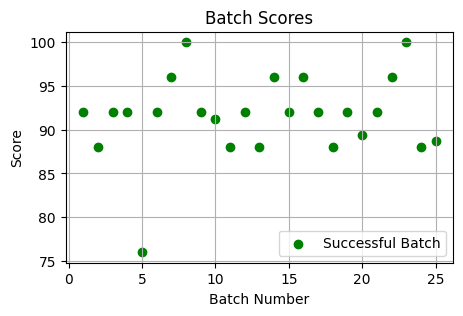

In [16]:
trial_logs = miprov2_mctsr.trial_logs
trial_numbers = list(trial_logs.keys())
scores = [trial_logs[trial]['score'] for trial in trial_numbers]

plt.figure(figsize=(5, 3))
for trial_number, score in zip(trial_numbers, scores):
    plt.scatter(trial_number, score, color='green', label='Successful Batch' if 'Successful Batch' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel('Batch Number')
plt.ylabel('Score')
plt.title('Batch Scores')
plt.grid(True)
plt.legend()
plt.show()

In [20]:
best_score = 0

def get_signature(predictor):
    if (hasattr(predictor, 'extended_signature')):
        return predictor.extended_signature
    elif (hasattr(predictor, 'signature')):
        return predictor.signature

print(f"Baseline program | Score: {best_score}:")
for i,predictor in enumerate(MCTSr().predictors()):
    print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
print()

print("----------------")

for trial_num in miprov2_mctsr.trial_logs:
    program_score = miprov2_mctsr.trial_logs[trial_num]["score"]
    if program_score > best_score:
        best_score = program_score
        best_program_so_far = miprov2_mctsr.trial_logs[trial_num]["program"]
        print(f"Best program after {trial_num} batches | Score: {best_score}:")
        for i,predictor in enumerate(best_program_so_far.predictors()):
            print(f"Prompt {i+1} Instruction: {get_signature(predictor).instructions}")
        print()

Baseline program | Score: 0:
Prompt 1 Instruction: Given the fields `problem`, produce the fields `answer`.
Prompt 2 Instruction: Given the fields `problem`, `current_answer`, produce the fields `critique`.
Prompt 3 Instruction: Given the fields `problem`, `answer`, produce the fields `score`.
Prompt 4 Instruction: [[ ## proposed_instruction ## ]]
Given a mathematical problem, a current answer, and a critique of that answer, refine the current answer to provide a more accurate and well-reasoned solution. 
Begin by carefully analyzing the problem and the critique, then think step by step to derive the correct answer. 
Ensure that your reasoning is clear and logical, and that the final answer is justified by the steps taken.

[[ ## completed ## ]]

----------------
Best program after 1 batches | Score: 92.0:
Prompt 1 Instruction: Given a mathematical problem, generate a detailed step-by-step reasoning process to derive the correct answer. Ensure that each step is logically sound and clea